In [1]:
# Importing necessary libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
def load_images_from_folder(folder_path):
    """
    Loads images and assigns labels based on folder names.

    Parameters:
        folder_path (str): Path to the dataset folder.

    Returns:
        images (list): List of image arrays.
        labels (list): List of corresponding labels.
        class_names (list): List of class names.
    """
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])  # Ensure consistent order
    class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = Image.open(img_path).convert('RGB')  # Ensure RGB
                    images.append(np.array(img))
                    labels.append(class_to_label[class_name])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return images, labels, class_names


In [3]:
def extract_color_histogram(image, patch_size=(32, 32), bins=8):
    """
    Extracts a 24-dimensional color histogram feature from an image.

    Parameters:
        image (np.ndarray): Image array.
        patch_size (tuple): Size of each patch (width, height).
        bins (int): Number of bins for the histogram per channel.

    Returns:
        features (np.ndarray): Array of shape (num_patches, 24).
    """
    # Resize image to 256x256
    image = Image.fromarray(image).resize((256, 256))
    image_np = np.array(image)

    features = []
    patch_width, patch_height = patch_size
    for i in range(0, 256, patch_width):
        for j in range(0, 256, patch_height):
            patch = image_np[i:i+patch_width, j:j+patch_height, :]
            hist_r, _ = np.histogram(patch[:, :, 0], bins=bins, range=(0, 256), density=True)
            hist_g, _ = np.histogram(patch[:, :, 1], bins=bins, range=(0, 256), density=True)
            hist_b, _ = np.histogram(patch[:, :, 2], bins=bins, range=(0, 256), density=True)
            hist = np.concatenate([hist_r, hist_g, hist_b])
            features.append(hist)
    return np.array(features)


In [4]:
def initialize_centroids(data, k):
    """
    Initializes centroids by randomly selecting k data points.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        k (int): Number of clusters.

    Returns:
        centroids (np.ndarray): Initialized centroids, shape (k, num_features).
    """
    np.random.seed(42)
    if data.shape[0] < k:
        raise ValueError(f"Number of clusters k={k} cannot exceed number of data points={data.shape[0]}.")
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]


In [5]:
def compute_distances(data, centroids):
    """
    Computes the Euclidean distance between each data point and each centroid.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        centroids (np.ndarray): Centroids, shape (k, num_features).

    Returns:
        distances (np.ndarray): Distances, shape (num_samples, k).
    """
    distances = np.sqrt(((data[:, np.newaxis, :] - centroids)**2).sum(axis=2))
    return distances


In [6]:
def kmeans(data, k, max_iters=100, tol=1e-4):
    """
    Performs K-Means clustering.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        k (int): Number of clusters.
        max_iters (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        centroids (np.ndarray): Final centroids, shape (k, num_features).
        labels (np.ndarray): Cluster assignments for each data point, shape (num_samples,).
    """
    centroids = initialize_centroids(data, k)
    for iteration in range(max_iters):
        distances = compute_distances(data, centroids)
        labels = np.argmin(distances, axis=1)

        # Compute new centroids
        new_centroids = []
        for i in range(k):
            cluster_data = data[labels == i]
            if cluster_data.size == 0:
                # If a cluster has no data points, reinitialize its centroid randomly
                new_centroid = data[np.random.choice(data.shape[0])]
                # print(f"Reinitializing centroid {i} as no data points are assigned to it.")
            else:
                new_centroid = cluster_data.mean(axis=0)
            new_centroids.append(new_centroid)
        new_centroids = np.array(new_centroids)

        # Compute shifts
        shifts = np.linalg.norm(new_centroids - centroids, axis=1)
        # print(f"Iteration {iteration+1}, Centroid shifts: {shifts}")

        # Check for convergence
        if np.max(shifts) < tol:
            # print(f"K-Means converged after {iteration+1} iterations.\n")
            break
        centroids = new_centroids
    return centroids, labels


In [7]:
def assign_clusters(features, centroids):
    """
    Assigns each feature to the nearest centroid.

    Parameters:
        features (np.ndarray): Feature vectors, shape (num_samples, num_features).
        centroids (np.ndarray): Centroids, shape (k, num_features).

    Returns:
        assignments (np.ndarray): Cluster assignments, shape (num_samples,).
    """
    distances = compute_distances(features, centroids)
    assignments = np.argmin(distances, axis=1)
    return assignments


In [8]:
def create_bovw(features, centroids, k):
    """
    Creates Bag-of-Visual-Words representation for each image.

    Parameters:
        features (np.ndarray): Feature vectors for all images, shape (num_images, feature_dim).
        centroids (np.ndarray): Centroids from K-Means, shape (k, feature_dim).
        k (int): Number of clusters.

    Returns:
        bovw_features (np.ndarray): BoVW feature vectors, shape (num_images, k).
    """
    bovw_features = []
    for feature in features:
        assignment = assign_clusters(feature.reshape(1, -1), centroids)[0]
        bovw = np.zeros(k)
        bovw[assignment] += 1
        bovw /= np.sum(bovw)  # Normalize
        bovw_features.append(bovw)
    return np.array(bovw_features)


In [9]:
def multivariate_gaussian(x, mean, cov):
    """
    Computes the multivariate Gaussian probability density function.

    Parameters:
        x (np.ndarray): Data point, shape (num_features,).
        mean (np.ndarray): Mean vector, shape (num_features,).
        cov (np.ndarray): Covariance matrix, shape (num_features, num_features).

    Returns:
        prob (float): Probability density.
    """
    size = len(mean)
    det = np.linalg.det(cov)
    if det == 0:
        det = 1e-6  # Regularization
    norm_const = 1.0 / (np.power((2*np.pi), float(size)/2) * np.power(det, 1.0/2))
    x_mu = x - mean
    inv = np.linalg.inv(cov)
    exponent = np.dot(np.dot(x_mu, inv), x_mu)
    prob = np.exp(-0.5 * exponent) * norm_const
    return prob


In [10]:
def initialize_gmm_parameters(data, k):
    """
    Initializes GMM parameters using K-Means clustering.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        k (int): Number of Gaussian components.

    Returns:
        weights (np.ndarray): Mixing coefficients, shape (k,).
        means (np.ndarray): Means of Gaussian components, shape (k, num_features).
        covariances (np.ndarray): Covariance matrices, shape (k, num_features, num_features).
    """
    centroids, labels = kmeans(data, k)
    weights = np.array([np.sum(labels == i) for i in range(k)]) / data.shape[0]
    means = centroids
    covariances = []
    for i in range(k):
        cluster_data = data[labels == i]
        if cluster_data.shape[0] > 0:
            cov = np.cov(cluster_data, rowvar=False) + np.eye(data.shape[1]) * 1e-6  # Regularization
        else:
            cov = np.eye(data.shape[1])  # If no data points assigned
        covariances.append(cov)
    covariances = np.array(covariances)
    return weights, means, covariances


In [11]:
def e_step(data, weights, means, covariances, k):
    """
    Performs the Expectation step of EM algorithm.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        weights (np.ndarray): Mixing coefficients, shape (k,).
        means (np.ndarray): Means of Gaussian components, shape (k, num_features).
        covariances (np.ndarray): Covariance matrices, shape (k, num_features, num_features).
        k (int): Number of Gaussian components.

    Returns:
        responsibilities (np.ndarray): Responsibilities, shape (num_samples, k).
    """
    num_samples = data.shape[0]
    responsibilities = np.zeros((num_samples, k))
    for i in range(k):
        for j in range(num_samples):
            responsibilities[j, i] = weights[i] * multivariate_gaussian(data[j], means[i], covariances[i])
    sum_responsibilities = responsibilities.sum(axis=1)[:, np.newaxis]
    responsibilities /= sum_responsibilities
    return responsibilities


In [12]:
def m_step(data, responsibilities, k):
    """
    Performs the Maximization step of EM algorithm.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        responsibilities (np.ndarray): Responsibilities, shape (num_samples, k).
        k (int): Number of Gaussian components.

    Returns:
        weights (np.ndarray): Updated mixing coefficients, shape (k,).
        means (np.ndarray): Updated means, shape (k, num_features).
        covariances (np.ndarray): Updated covariance matrices, shape (k, num_features, num_features).
    """
    Nk = responsibilities.sum(axis=0)  # shape (k,)

    # Avoid division by zero
    Nk = np.where(Nk == 0, 1e-10, Nk)

    weights = Nk / data.shape[0]
    means = np.dot(responsibilities.T, data) / Nk[:, np.newaxis]

    covariances = []
    for i in range(k):
        diff = data - means[i]
        weighted_diff = responsibilities[:, i][:, np.newaxis] * diff
        cov = np.dot(weighted_diff.T, diff) / Nk[i]
        cov += np.eye(data.shape[1]) * 1e-6  # Regularization
        covariances.append(cov)
    covariances = np.array(covariances)
    return weights, means, covariances


In [13]:
def compute_log_likelihood(data, weights, means, covariances, k):
    """
    Computes the log likelihood of the data under the current GMM parameters.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        weights (np.ndarray): Mixing coefficients, shape (k,).
        means (np.ndarray): Means of Gaussian components, shape (k, num_features).
        covariances (np.ndarray): Covariance matrices, shape (k, num_features, num_features).
        k (int): Number of Gaussian components.

    Returns:
        log_likelihood (float): Log likelihood value.
    """
    num_samples = data.shape[0]
    total = np.zeros(num_samples)
    for i in range(k):
        for j in range(num_samples):
            total[j] += weights[i] * multivariate_gaussian(data[j], means[i], covariances[i])
    log_likelihood = np.sum(np.log(total + 1e-10))  # Adding epsilon to prevent log(0)
    return log_likelihood


In [14]:
def gmm_em(data, k, max_iters=100, tol=1e-4):
    """
    Fits a Gaussian Mixture Model to the data using the EM algorithm.

    Parameters:
        data (np.ndarray): Data points, shape (num_samples, num_features).
        k (int): Number of Gaussian components.
        max_iters (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        weights (np.ndarray): Mixing coefficients, shape (k,).
        means (np.ndarray): Means of Gaussian components, shape (k, num_features).
        covariances (np.ndarray): Covariance matrices, shape (k, num_features, num_features).
    """
    weights, means, covariances = initialize_gmm_parameters(data, k)
    log_likelihood = compute_log_likelihood(data, weights, means, covariances, k)
    # print(f"Initial Log Likelihood: {log_likelihood}")

    for iteration in range(max_iters):
        # E-step
        responsibilities = e_step(data, weights, means, covariances, k)

        # M-step
        weights, means, covariances = m_step(data, responsibilities, k)

        # Compute log likelihood
        new_log_likelihood = compute_log_likelihood(data, weights, means, covariances, k)
        # print(f"Iteration {iteration+1}, Log Likelihood: {new_log_likelihood}")

        # Check for convergence
        if abs(new_log_likelihood - log_likelihood) < tol:
            # print(f"GMM converged after {iteration+1} iterations.\n")
            break
        log_likelihood = new_log_likelihood

    return weights, means, covariances


In [15]:
def train_bayes_classifier(X_train, y_train, num_classes, k_components):
    """
    Trains a Bayes classifier using GMMs for each class.

    Parameters:
        X_train (np.ndarray): Training feature vectors, shape (num_samples, num_features).
        y_train (list or np.ndarray): Training labels, shape (num_samples,).
        num_classes (int): Number of classes.
        k_components (int): Number of GMM components per class.

    Returns:
        gmm_models (dict): Dictionary of GMM parameters for each class.
    """
    gmm_models = {}
    for cls in range(num_classes):
        print(f"Training GMM for class {cls} with {k_components} components.")
        class_data = X_train[y_train == cls]
        if class_data.shape[0] < k_components:
            print(f"  Skipping class {cls} as it has fewer samples ({class_data.shape[0]}) than k_components ({k_components}).")
            continue
        weights, means, covariances = gmm_em(class_data, k_components)
        gmm_models[cls] = {
            'weights': weights,
            'means': means,
            'covariances': covariances
        }
    return gmm_models


In [16]:
def predict_bayes_classifier(X_test, gmm_models, num_classes, k_components):
    """
    Predicts class labels for the test data using the trained GMMs.

    Parameters:
        X_test (np.ndarray): Testing feature vectors, shape (num_samples, num_features).
        gmm_models (dict): Dictionary of GMM parameters for each class.
        num_classes (int): Number of classes.
        k_components (int): Number of GMM components per class.

    Returns:
        predictions (list): Predicted class labels.
    """
    predictions = []
    for idx, x in enumerate(X_test):
        posterior_probs = []
        for cls in range(num_classes):
            if cls not in gmm_models:
                # If a class was skipped during training due to insufficient samples
                posterior_probs.append(0)
                continue
            gmm = gmm_models[cls]
            prob = 0
            for i in range(k_components):
                prob += gmm['weights'][i] * multivariate_gaussian(x, gmm['means'][i], gmm['covariances'][i])
            posterior_probs.append(prob)
        predicted_class = np.argmax(posterior_probs)
        predictions.append(predicted_class)
        if (idx+1) % 100 == 0:
            print(f"Predicted {idx+1} samples.")
    return predictions


In [17]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    """
    Computes the confusion matrix.

    Parameters:
        y_true (list or np.ndarray): True class labels.
        y_pred (list or np.ndarray): Predicted class labels.
        num_classes (int): Number of classes.

    Returns:
        confusion_matrix (np.ndarray): Confusion matrix, shape (num_classes, num_classes).
    """
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        confusion_matrix[true][pred] += 1
    return confusion_matrix


In [18]:
def compute_metrics(confusion_matrix):
    """
    Computes accuracy, precision, recall, and F1-score.

    Parameters:
        confusion_matrix (np.ndarray): Confusion matrix.

    Returns:
        metrics (dict): Dictionary containing all metrics.
    """
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1_score)

    metrics = {
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_score_per_class': f1_score,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1_score': mean_f1,
        'accuracy': accuracy
    }

    return metrics


In [19]:
def plot_confusion_matrix(confusion_matrix, class_names, title='Confusion Matrix'):
    """
    Plots the confusion matrix.

    Parameters:
        confusion_matrix (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [20]:

def plot_metrics(results, feature_type):
    """
    Plots accuracy, precision, recall, and F1-score against the number of GMM mixtures.

    Parameters:
        results (dict): Dictionary containing metrics and mixture numbers.
        feature_type (str): Description of the feature type (e.g., 'Color Histogram').
    """
    mixtures = results['mixtures']
    plt.figure(figsize=(12, 10))

    plt.suptitle(f'{feature_type}', fontsize=16, y=1.02)

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(mixtures, results['accuracy'], marker='o', linestyle='-', color='blue')
    plt.title(' Accuracy vs Number of Mixtures')
    plt.xlabel('Number of Mixtures')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Mean Precision
    plt.subplot(2, 2, 2)
    plt.plot(mixtures, results['mean_precision'], marker='o', linestyle='-', color='green')
    plt.title(' Mean Precision vs Number of Mixtures')
    plt.xlabel('Number of Mixtures')
    plt.ylabel('Mean Precision')
    plt.grid(True)

    # Mean Recall
    plt.subplot(2, 2, 3)
    plt.plot(mixtures, results['mean_recall'], marker='o', linestyle='-', color='red')
    plt.title(' Mean Recall vs Number of Mixtures')
    plt.xlabel('Number of Mixtures')
    plt.ylabel('Mean Recall')
    plt.grid(True)

    # Mean F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(mixtures, results['mean_f1_score'], marker='o', linestyle='-', color='purple')
    plt.title(' Mean F1-Score vs Number of Mixtures')
    plt.xlabel('Number of Mixtures')
    plt.ylabel('Mean F1-Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
def plot_comparative_accuracy(results1, results2, label1, label2):
    """
    Plots the accuracy of two feature types against the number of GMM mixtures.

    Parameters:
        results1 (dict): Metrics for the first feature type.
        results2 (dict): Metrics for the second feature type.
        label1 (str): Label for the first feature type.
        label2 (str): Label for the second feature type.
    """
    mixtures1 = results1['mixtures']
    accuracy1 = results1['accuracy']

    mixtures2 = results2['mixtures']
    accuracy2 = results2['accuracy']

    plt.figure(figsize=(8,6))
    plt.plot(mixtures1, accuracy1, marker='o', linestyle='-', color='blue', label=label1)
    plt.plot(mixtures2, accuracy2, marker='s', linestyle='--', color='orange', label=label2)
    plt.title('Comparative Accuracy vs Number of GMM Mixtures')
    plt.xlabel('Number of Mixtures')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
# Define paths
train_path = '/content/drive/MyDrive/group06/train'
test_path = '/content/drive/MyDrive/group06/test'

# Load training and testing data
print("Loading training data...")
train_images, train_labels, class_names = load_images_from_folder(train_path)
print(f"Loaded {len(train_images)} training images.")

print("\nLoading testing data...")
test_images, test_labels, _ = load_images_from_folder(test_path)
print(f"Loaded {len(test_images)} testing images.\n")


Loading training data...


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/group06/train'

In [128]:
# Extract color histogram features for all training images
print("Extracting color histogram features for training data...")
train_features_color = []
for idx, img in enumerate(train_images):
    hist = extract_color_histogram(img)
    avg_hist = hist.mean(axis=0)  # Average over patches to get a single feature vector per image
    train_features_color.append(avg_hist)
    if (idx+1) % 50 == 0:
        print(f"  Processed {idx+1}/{len(train_images)} training images.")
train_features_color = np.array(train_features_color)
print(f"Extracted features for {train_features_color.shape[0]} training images.\n")

# Extract color histogram features for all testing images
print("Extracting color histogram features for testing data...")
test_features_color = []
for idx, img in enumerate(test_images):
    hist = extract_color_histogram(img)
    avg_hist = hist.mean(axis=0)  # Average over patches to get a single feature vector per image
    test_features_color.append(avg_hist)
    if (idx+1) % 10 == 0:
        print(f"  Processed {idx+1}/{len(test_images)} testing images.")
test_features_color = np.array(test_features_color)
print(f"Extracted features for {test_features_color.shape[0]} testing images.\n")


Extracting color histogram features for training data...
  Processed 50/150 training images.
  Processed 100/150 training images.
  Processed 150/150 training images.
Extracted features for 150 training images.

Extracting color histogram features for testing data...
  Processed 10/150 testing images.
  Processed 20/150 testing images.
  Processed 30/150 testing images.
  Processed 40/150 testing images.
  Processed 50/150 testing images.
  Processed 60/150 testing images.
  Processed 70/150 testing images.
  Processed 80/150 testing images.
  Processed 90/150 testing images.
  Processed 100/150 testing images.
  Processed 110/150 testing images.
  Processed 120/150 testing images.
  Processed 130/150 testing images.
  Processed 140/150 testing images.
  Processed 150/150 testing images.
Extracted features for 150 testing images.



In [129]:
# Perform K-Means clustering on training color histogram features
k = 32  # Number of clusters
print(f"Performing K-Means clustering with k={k}...")
centroids_color, labels_color = kmeans(train_features_color, k)
print("K-Means clustering completed.\n")


Performing K-Means clustering with k=32...
K-Means clustering completed.



In [130]:
# Create BoVW features for training data
print("Creating BoVW features for training data...")
train_bovw_color = create_bovw(train_features_color, centroids_color, k)
print(f"BoVW features for training data: {train_bovw_color.shape}\n")

# Create BoVW features for testing data
print("Creating BoVW features for testing data...")
test_bovw_color = create_bovw(test_features_color, centroids_color, k)
print(f"BoVW features for testing data: {test_bovw_color.shape}\n")


Creating BoVW features for training data...
BoVW features for training data: (150, 32)

Creating BoVW features for testing data...
BoVW features for testing data: (150, 32)



In [131]:
# Convert training labels to a NumPy array if not already
train_labels_np = np.array(train_labels)

# Get unique classes and their counts
unique_classes, class_counts = np.unique(train_labels_np, return_counts=True)

print("Number of training samples per class:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

# Find the minimum number of samples across all classes
min_samples = class_counts.min()
print(f"\nMinimum number of samples across all classes: {min_samples}")

# Define the desired number of mixtures
desired_mixtures = [1, 2, 4, 8, 16]

# Filter mixtures to ensure they do not exceed min_samples
valid_mixtures = [k for k in desired_mixtures if k <= min_samples]
print(f"\nUsing the following number of mixtures for experiments: {valid_mixtures}\n")


Number of training samples per class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Minimum number of samples across all classes: 50

Using the following number of mixtures for experiments: [1, 2, 4, 8, 16]



In [132]:
def train_evaluate_classifier(X_train, y_train, X_test, y_test, num_classes, k_components):
    """
    Trains the Bayes classifier with GMMs and evaluates its performance.

    Parameters:
        X_train (np.ndarray): Training feature vectors, shape (num_samples, num_features).
        y_train (np.ndarray): Training labels, shape (num_samples,).
        X_test (np.ndarray): Testing feature vectors, shape (num_samples, num_features).
        y_test (np.ndarray): Testing labels, shape (num_samples,).
        num_classes (int): Number of classes.
        k_components (int): Number of GMM components per class.

    Returns:
        metrics (dict): Evaluation metrics.
        confusion_matrix (np.ndarray): Confusion matrix.
    """
    # Check if k_components exceeds the number of samples in any class
    class_counts = np.array([np.sum(y_train == cls) for cls in range(num_classes)])
    if np.any(class_counts < k_components):
        raise ValueError(f"k_components ({k_components}) exceeds the number of samples in at least one class.")

    # Train Bayes Classifier
    gmm_models = train_bayes_classifier(X_train, y_train, num_classes, k_components)

    # Predict on Test Data
    predictions = predict_bayes_classifier(X_test, gmm_models, num_classes, k_components)

    # Compute Confusion Matrix
    confusion_matrix = compute_confusion_matrix(y_test, predictions, num_classes)

    # Compute Metrics
    metrics = compute_metrics(confusion_matrix)

    return metrics, confusion_matrix


In [133]:
# Initialize dictionaries to store results for both feature types
results_color = {
    'mixtures': [],
    'accuracy': [],
    'mean_precision': [],
    'mean_recall': [],
    'mean_f1_score': [],
    'confusion_matrices': []
}

results_bovw = {
    'mixtures': [],
    'accuracy': [],
    'mean_precision': [],
    'mean_recall': [],
    'mean_f1_score': [],
    'confusion_matrices': []
}


===== Number of Mixtures: 1 =====

>>> Feature Type: 24-Dimensional Color Histogram
Training GMM for class 0 with 1 components.
Training GMM for class 1 with 1 components.
Training GMM for class 2 with 1 components.
Predicted 100 samples.
Accuracy: 0.6533
Mean Precision: 0.6490
Mean Recall: 0.6533
Mean F1-Score: 0.6367

Confusion Matrix:
19 12 19
9 36 5
3 4 43




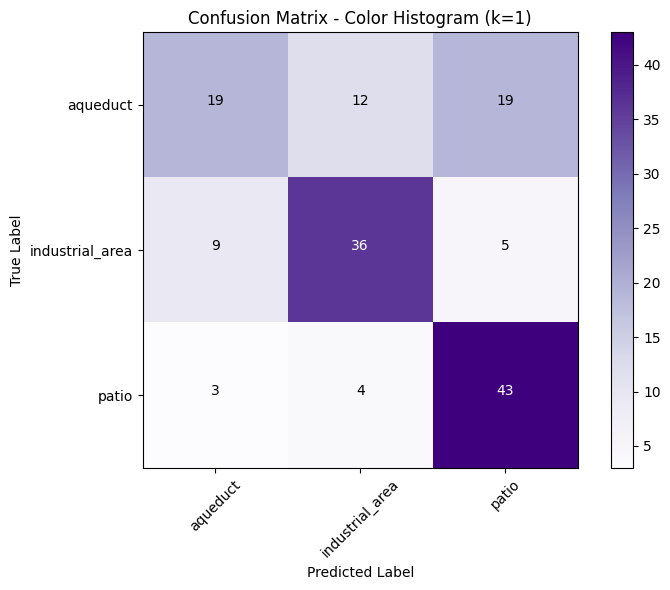

>>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)
Training GMM for class 0 with 1 components.
Training GMM for class 1 with 1 components.
Training GMM for class 2 with 1 components.
Predicted 100 samples.
Accuracy: 0.4933
Mean Precision: 0.4565
Mean Recall: 0.4933
Mean F1-Score: 0.4076

Confusion Matrix:
1 10 39
2 26 22
1 2 47




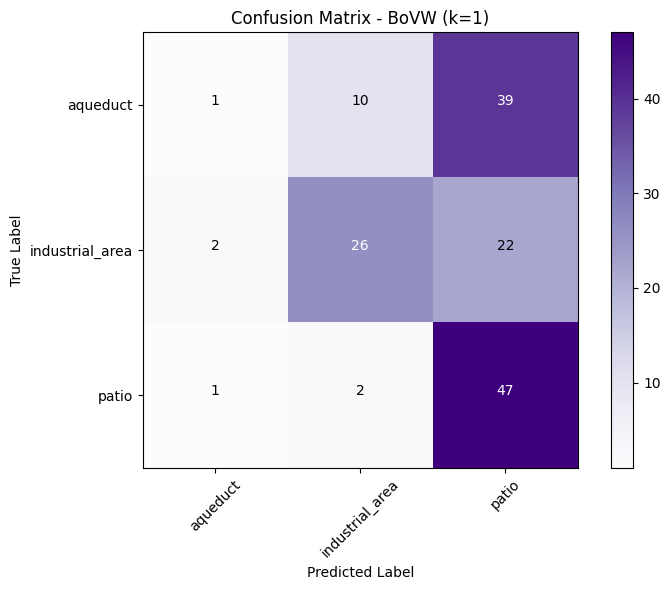

===== Number of Mixtures: 2 =====

>>> Feature Type: 24-Dimensional Color Histogram
Training GMM for class 0 with 2 components.
Training GMM for class 1 with 2 components.
Training GMM for class 2 with 2 components.
Predicted 100 samples.
Accuracy: 0.6267
Mean Precision: 0.6196
Mean Recall: 0.6267
Mean F1-Score: 0.6109

Confusion Matrix:
18 15 17
6 38 6
7 5 38




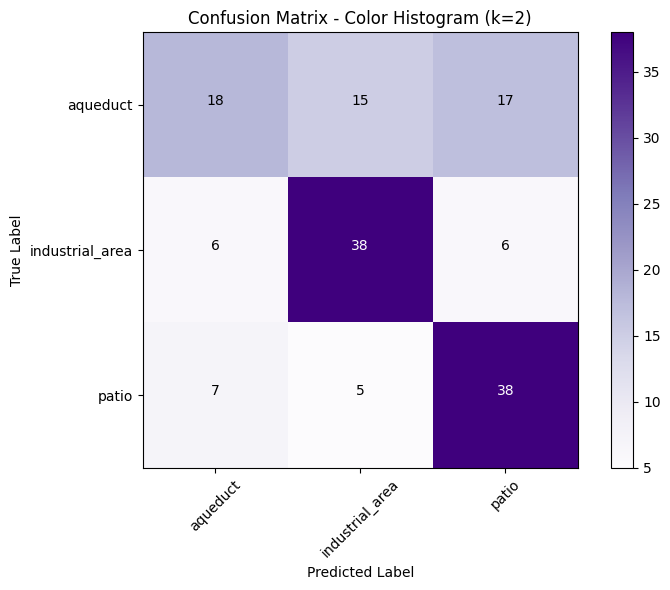

>>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)
Training GMM for class 0 with 2 components.
Training GMM for class 1 with 2 components.
Training GMM for class 2 with 2 components.
Predicted 100 samples.
Accuracy: 0.5067
Mean Precision: 0.5525
Mean Recall: 0.5067
Mean F1-Score: 0.4356

Confusion Matrix:
3 8 39
2 26 22
1 2 47




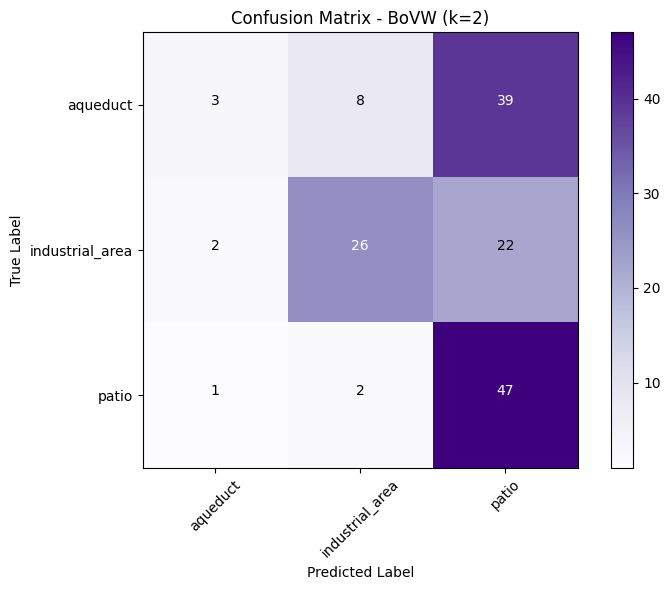

===== Number of Mixtures: 4 =====

>>> Feature Type: 24-Dimensional Color Histogram
Training GMM for class 0 with 4 components.
Training GMM for class 1 with 4 components.
Training GMM for class 2 with 4 components.
Predicted 100 samples.
Accuracy: 0.5800
Mean Precision: 0.5736
Mean Recall: 0.5800
Mean F1-Score: 0.5725

Confusion Matrix:
20 17 13
13 30 7
5 8 37




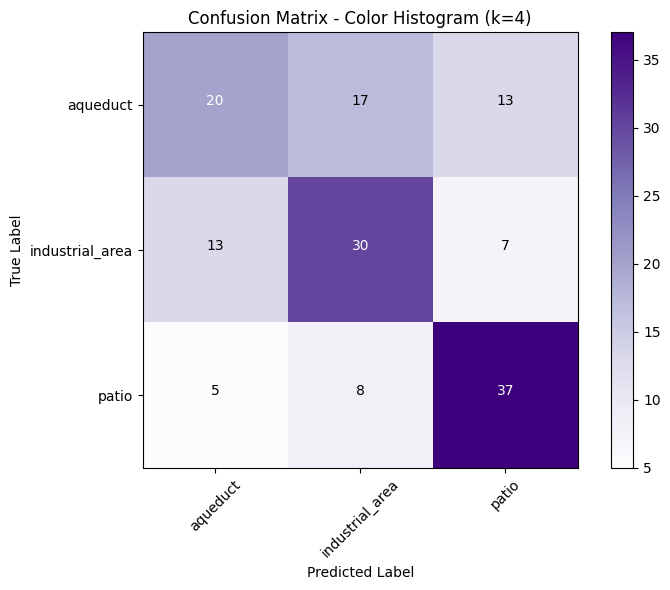

>>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)
Training GMM for class 0 with 4 components.
Training GMM for class 1 with 4 components.
Training GMM for class 2 with 4 components.
Predicted 100 samples.
Accuracy: 0.5267
Mean Precision: 0.6041
Mean Recall: 0.5267
Mean F1-Score: 0.4739

Confusion Matrix:
6 8 36
2 28 20
1 4 45




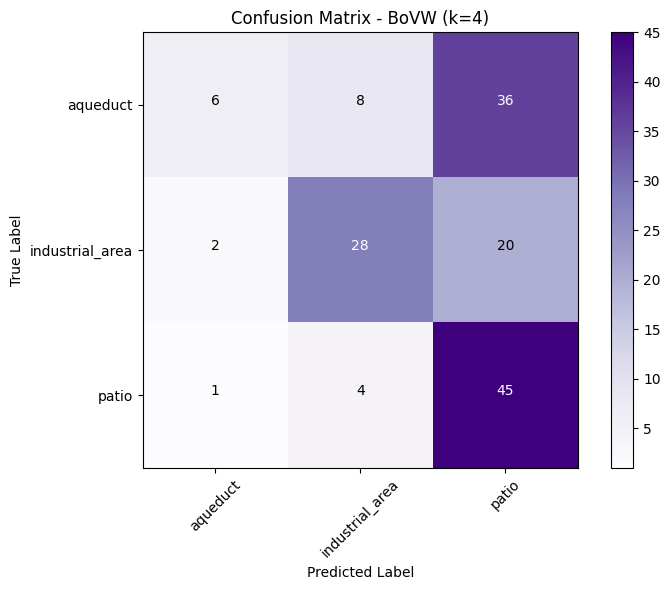

===== Number of Mixtures: 8 =====

>>> Feature Type: 24-Dimensional Color Histogram
Training GMM for class 0 with 8 components.
Training GMM for class 1 with 8 components.
Training GMM for class 2 with 8 components.
Predicted 100 samples.
Accuracy: 0.5733
Mean Precision: 0.5754
Mean Recall: 0.5733
Mean F1-Score: 0.5661

Confusion Matrix:
20 17 13
11 30 9
3 11 36




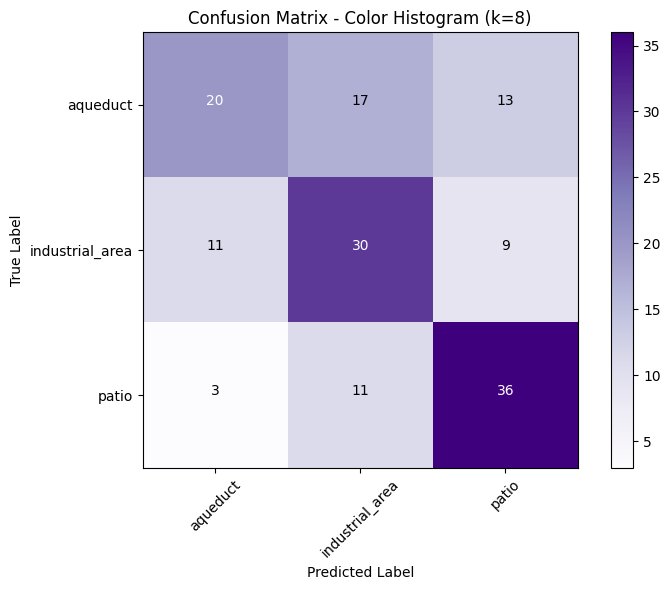

>>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)
Training GMM for class 0 with 8 components.
Training GMM for class 1 with 8 components.
Training GMM for class 2 with 8 components.
Predicted 100 samples.
Accuracy: 0.5267
Mean Precision: 0.5496
Mean Recall: 0.5267
Mean F1-Score: 0.5068

Confusion Matrix:
13 9 28
6 27 17
5 6 39




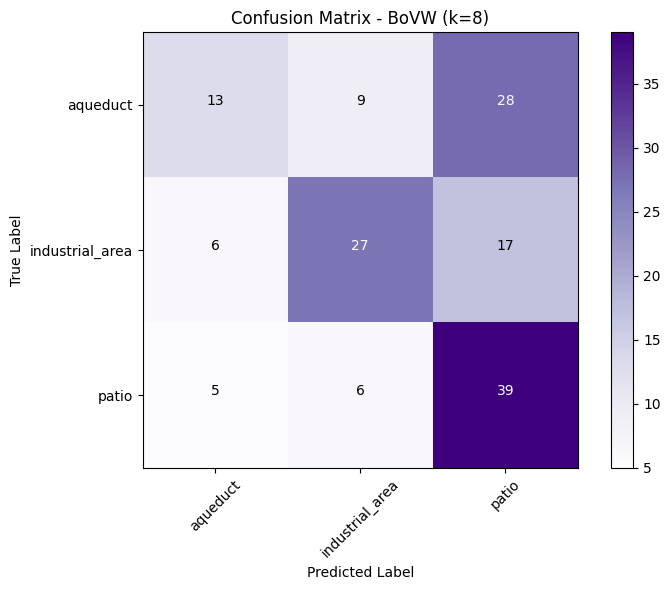

===== Number of Mixtures: 16 =====

>>> Feature Type: 24-Dimensional Color Histogram
Training GMM for class 0 with 16 components.
Training GMM for class 1 with 16 components.
Training GMM for class 2 with 16 components.
Predicted 100 samples.
Accuracy: 0.5000
Mean Precision: 0.4937
Mean Recall: 0.5000
Mean F1-Score: 0.4931

Confusion Matrix:
21 14 15
17 20 13
8 8 34




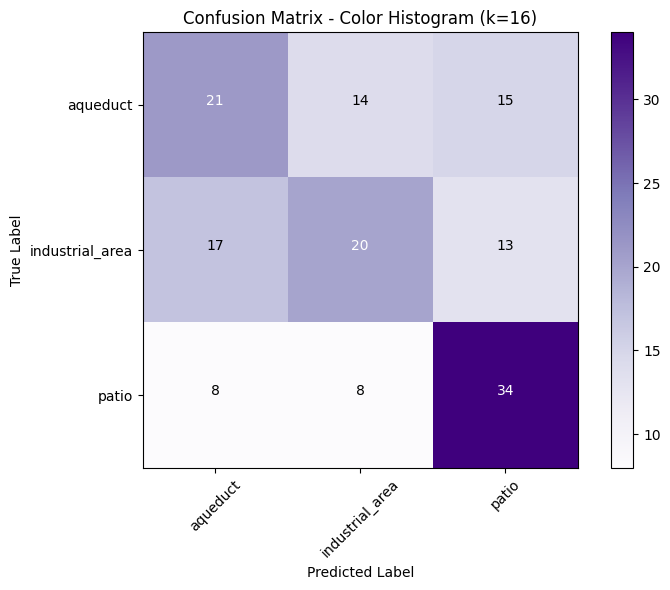

>>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)
Training GMM for class 0 with 16 components.
Training GMM for class 1 with 16 components.
Training GMM for class 2 with 16 components.
Predicted 100 samples.
Accuracy: 0.5333
Mean Precision: 0.5504
Mean Recall: 0.5333
Mean F1-Score: 0.5170

Confusion Matrix:
15 12 23
6 27 17
5 7 38




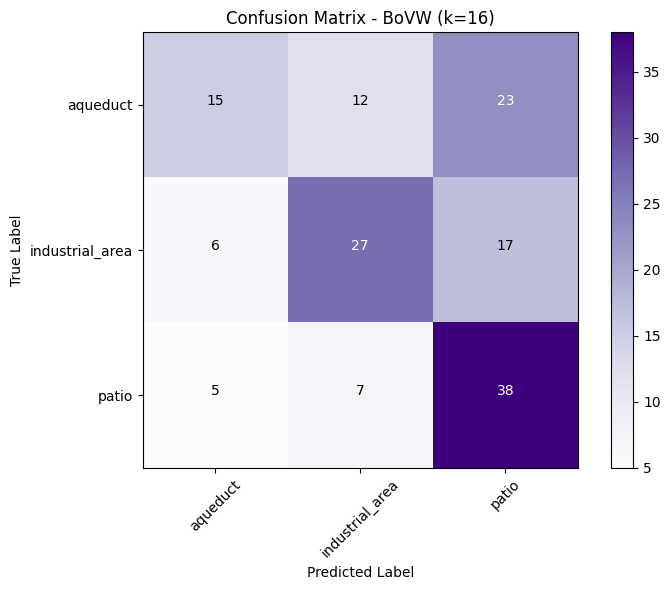

In [134]:
# Number of classes
num_classes = len(class_names)

# Perform experiments for each valid number of mixtures
for k_mixture in valid_mixtures:
    print(f"===== Number of Mixtures: {k_mixture} =====\n")

    # --- Experiments with 24-Dimensional Color Histogram ---
    print(">>> Feature Type: 24-Dimensional Color Histogram")
    try:
        metrics_color, confusion_matrix_color = train_evaluate_classifier(
            X_train=train_features_color,
            y_train=train_labels_np,
            X_test=test_features_color,
            y_test=test_labels,
            num_classes=num_classes,
            k_components=k_mixture
        )

        # Store the results
        results_color['mixtures'].append(k_mixture)
        results_color['accuracy'].append(metrics_color['accuracy'])
        results_color['mean_precision'].append(metrics_color['mean_precision'])
        results_color['mean_recall'].append(metrics_color['mean_recall'])
        results_color['mean_f1_score'].append(metrics_color['mean_f1_score'])
        results_color['confusion_matrices'].append(confusion_matrix_color)

        # Display the metrics
        print(f"Accuracy: {metrics_color['accuracy']:.4f}")
        print(f"Mean Precision: {metrics_color['mean_precision']:.4f}")
        print(f"Mean Recall: {metrics_color['mean_recall']:.4f}")
        print(f"Mean F1-Score: {metrics_color['mean_f1_score']:.4f}\n")

        # Print the confusion matrix in matrix form
        print("Confusion Matrix:")
        for row in confusion_matrix_color:
            print(' '.join(map(str, row)))
        print("\n")

        # Optionally, plot the confusion matrix
        plot_confusion_matrix(confusion_matrix_color, class_names, title=f'Confusion Matrix - Color Histogram (k={k_mixture})')
    except ValueError as ve:
        print(f"Skipping due to error: {ve}\n")

    # --- Experiments with 32-Dimensional BoVW ---
    print(">>> Feature Type: 32-Dimensional Bag-of-Visual-Words (BoVW)")
    try:
        metrics_bovw, confusion_matrix_bovw = train_evaluate_classifier(
            X_train=train_bovw_color,
            y_train=train_labels_np,
            X_test=test_bovw_color,
            y_test=test_labels,
            num_classes=num_classes,
            k_components=k_mixture
        )

        # Store the results
        results_bovw['mixtures'].append(k_mixture)
        results_bovw['accuracy'].append(metrics_bovw['accuracy'])
        results_bovw['mean_precision'].append(metrics_bovw['mean_precision'])
        results_bovw['mean_recall'].append(metrics_bovw['mean_recall'])
        results_bovw['mean_f1_score'].append(metrics_bovw['mean_f1_score'])
        results_bovw['confusion_matrices'].append(confusion_matrix_bovw)

        # Display the metrics
        print(f"Accuracy: {metrics_bovw['accuracy']:.4f}")
        print(f"Mean Precision: {metrics_bovw['mean_precision']:.4f}")
        print(f"Mean Recall: {metrics_bovw['mean_recall']:.4f}")
        print(f"Mean F1-Score: {metrics_bovw['mean_f1_score']:.4f}\n")

        # Print the confusion matrix in matrix form
        print("Confusion Matrix:")
        for row in confusion_matrix_bovw:
            print(' '.join(map(str, row)))
        print("\n")

        # Optionally, plot the confusion matrix
        plot_confusion_matrix(confusion_matrix_bovw, class_names, title=f'Confusion Matrix - BoVW (k={k_mixture})')
    except ValueError as ve:
        print(f"Skipping due to error: {ve}\n")


In [135]:
def print_results_table(results, feature_type):
    """
    Prints the results in a tabular format.

    Parameters:
        results (dict): Dictionary containing metrics and mixture numbers.
        feature_type (str): Description of the feature type.
    """
    print(f"===== Results for {feature_type} =====")
    print("Number of Mixtures\tAccuracy\tMean Precision\tMean Recall\tMean F1-Score")
    for i in range(len(results['mixtures'])):
        print(f"{i}\t\t{results['mixtures'][i]}\t\t{results['accuracy'][i]:.6f}\t{results['mean_precision'][i]:.6f}\t{results['mean_recall'][i]:.6f}\t{results['mean_f1_score'][i]:.6f}")
    print("\n")


In [136]:
# Print results for Color Histogram
print_results_table(results_color, '24-Dimensional Color Histogram')

# Print results for BoVW
print_results_table(results_bovw, '32-Dimensional Bag-of-Visual-Words (BoVW)')


===== Results for 24-Dimensional Color Histogram =====
Number of Mixtures	Accuracy	Mean Precision	Mean Recall	Mean F1-Score
0		1		0.653333	0.649001	0.653333	0.636687
1		2		0.626667	0.619589	0.626667	0.610944
2		4		0.580000	0.573631	0.580000	0.572521
3		8		0.573333	0.575389	0.573333	0.566138
4		16		0.500000	0.493700	0.500000	0.493142


===== Results for 32-Dimensional Bag-of-Visual-Words (BoVW) =====
Number of Mixtures	Accuracy	Mean Precision	Mean Recall	Mean F1-Score
0		1		0.493333	0.456465	0.493333	0.407628
1		2		0.506667	0.552469	0.506667	0.435577
2		4		0.526667	0.604070	0.526667	0.473880
3		8		0.526667	0.549603	0.526667	0.506799
4		16		0.533333	0.550353	0.533333	0.516996




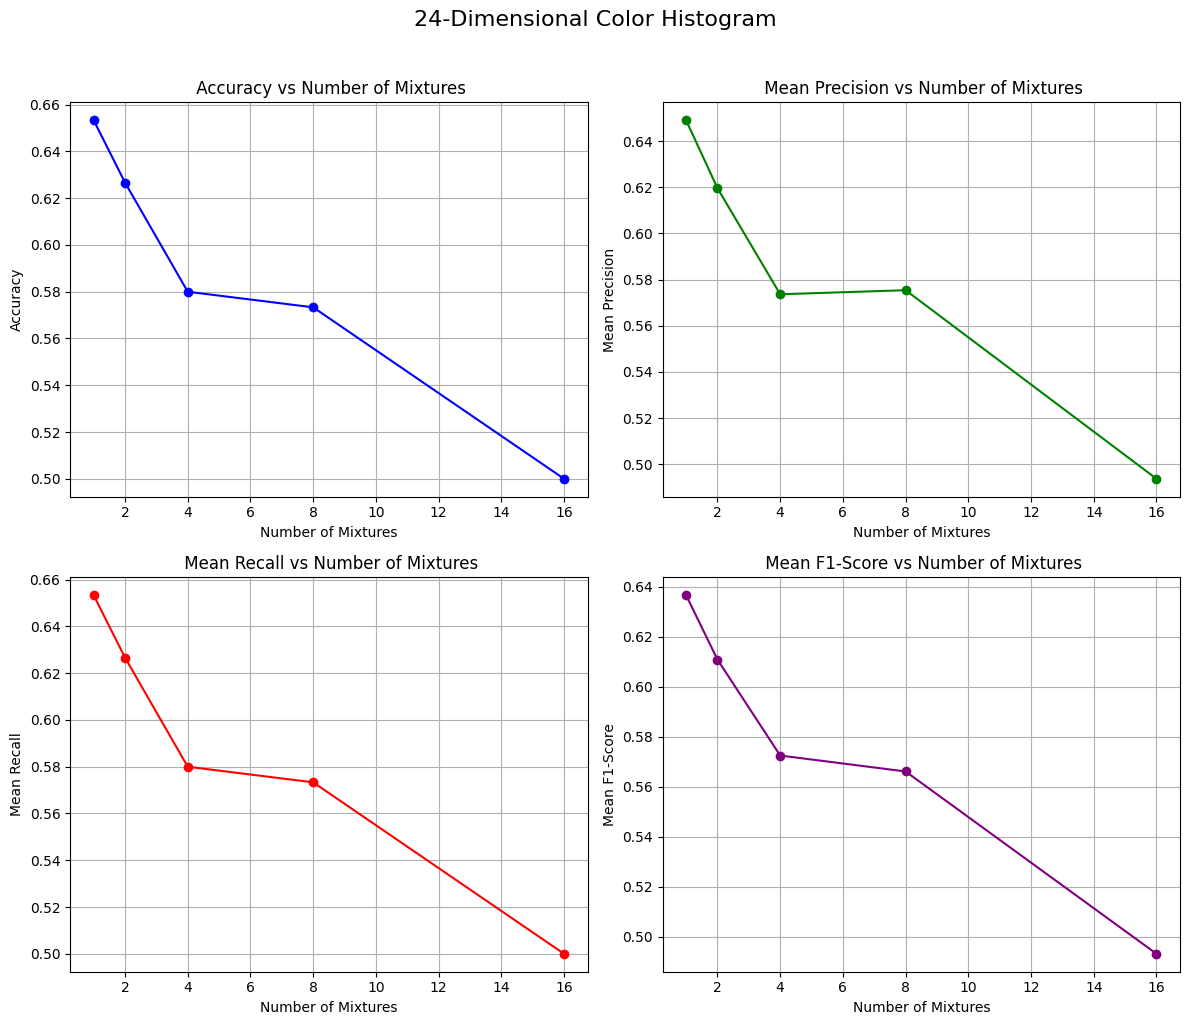

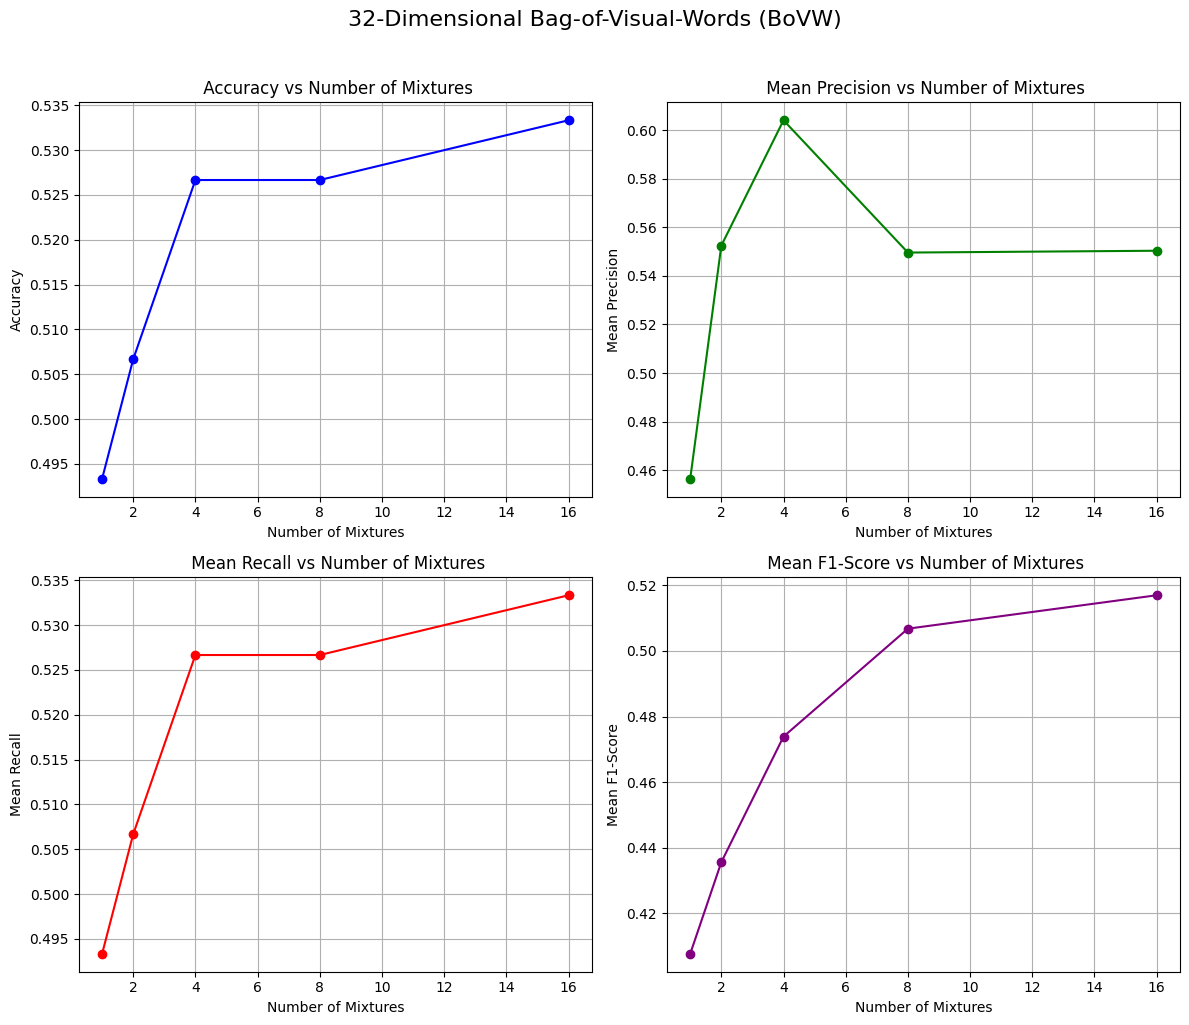

In [137]:
# Plot metrics for Color Histogram
plot_metrics(results_color, '24-Dimensional Color Histogram')

# Plot metrics for BoVW
plot_metrics(results_bovw, '32-Dimensional Bag-of-Visual-Words (BoVW)')


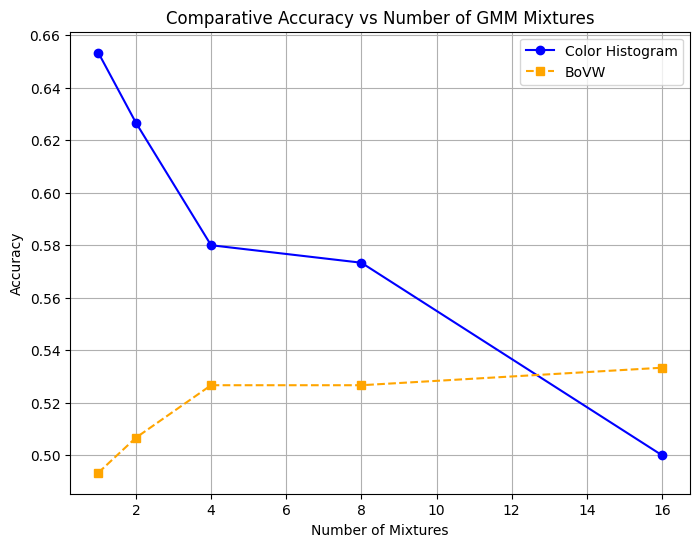

In [138]:
# Plot comparative accuracy
plot_comparative_accuracy(results_color, results_bovw, 'Color Histogram', 'BoVW')
